We followed the instruction at https://github.com/guyz/twitter-sentiment-dataset#installation to obtain the 5K labeled Twitter dataset.

In [1]:
%pylab inline

import nltk
import pandas as pd
from sklearn.utils import shuffle
from keras.datasets import imdb
from keras.preprocessing import sequence
from keras.models import load_model

from wordcloud import WordCloud
from sklearn.model_selection import train_test_split

pd.options.display.max_colwidth = 200

Populating the interactive namespace from numpy and matplotlib


Using TensorFlow backend.


In [2]:
df = pd.read_csv('data/tweets.csv')

In [3]:
sentiment_groups = list(df.groupby(by='Sentiment'))
[(name, len(table)) for (name, table) in sentiment_groups]

[('irrelevant', 1464), ('negative', 477), ('neutral', 2018), ('positive', 430)]

There are 4 groups corresponding to 4 sentiments. Let's see how many examples corresponding to `negative` and `positive` sentiments.

There are just 477 negative tweets and 430 positive tweets. This constitutes a trainable dataset of less than 1000 tweets. Even for transfer learning, this dataset is still twoo small. The whole dataset is barely enough to serve as a held-out test set.

Therefore, we will use the sentiment analysis model trained on the IMDB dataset and apply it on this Twitter dataset and see how it performs.

## Word Cloud
First, let's do some visualization analysis with word clouds to see how they are different for negative, neutral, and positive tweets.

In [4]:
group = sentiment_groups[0]
wordcloud = WordCloud().generate('\n'.join(group[1].TweetText))

### Word clouds with company names included

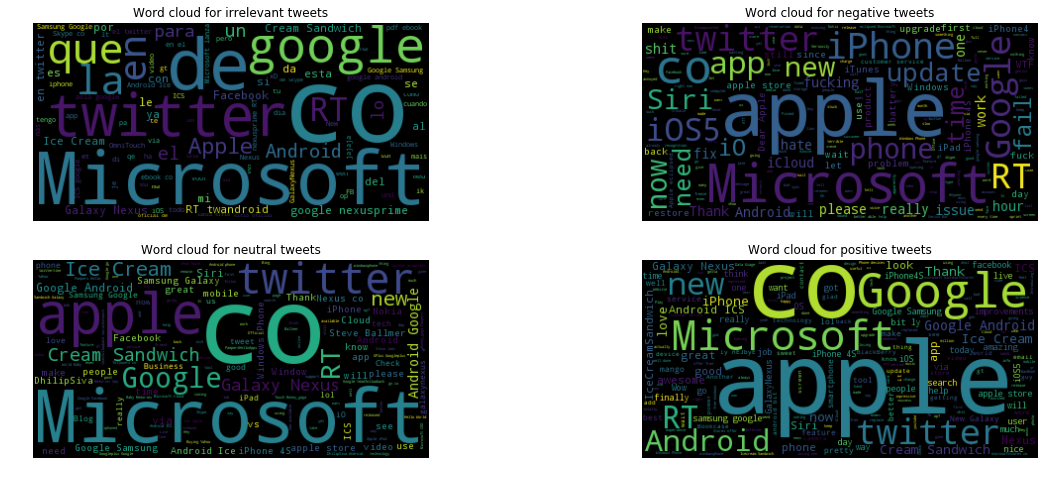

In [5]:
rcParams['figure.figsize'] = 20, 8

for i, group in enumerate(sentiment_groups):
    wordcloud = WordCloud(font_step=2).generate('\n'.join(group[1].TweetText))
    plt.subplot(2,2,i+1)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.title('Word cloud for {0} tweets'.format(group[0]))
    plt.axis('off');

### Word clouds with stop words excluded
Some stop words may include company names because they appear too frequently, due to the way the data was collected.

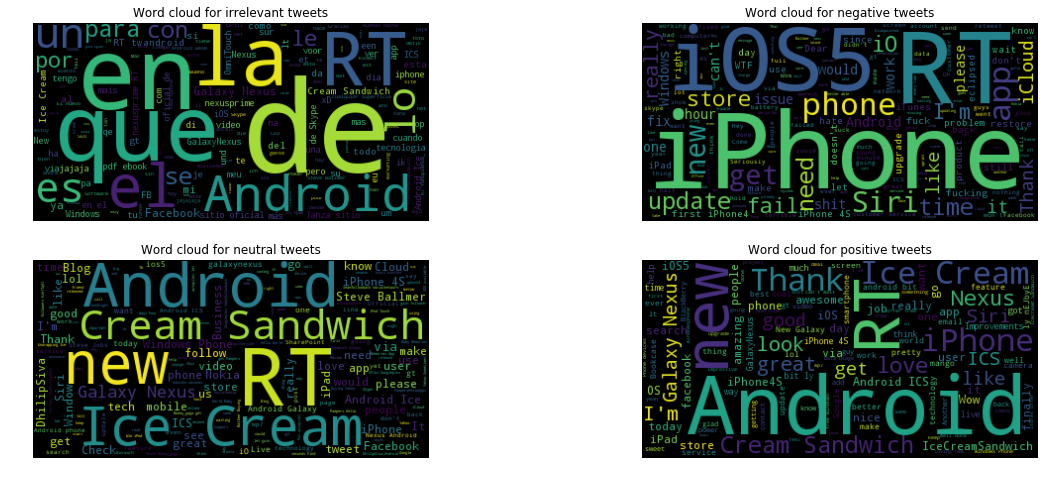

In [6]:
noisy_words = nltk.corpus.stopwords.words('english') + ['Microsoft', 'Apple', 'Google', 'Twitter', 'Samsung'] + ['http', 'CO']

for i, group in enumerate(sentiment_groups):
    wordcloud = WordCloud(font_step=2, stopwords=noisy_words).generate('\n'.join(group[1].TweetText))
    plt.subplot(2,2,i+1)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.title('Word cloud for {0} tweets'.format(group[0]))
    plt.axis('off');

It is interesting that Android tends to associate more with positive sentiment while iPhone tends to associate more with negative sentiment, on the Twitter sphere, per the small sample that we have.

The short period of could also introduce a strong bias.

________

### Test pretrained Keras model on this small Tweet sentiment dataset

In [7]:
#Convert words to word ID
word_index = imdb.get_word_index()
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')

max_features = 5000
start_word = 1
oov_word = 2
index_from = 3

df['words'] = [tokenizer.tokenize(tweet.lower()) for tweet in df.TweetText]
df['word_indices'] = [[start_word] + 
                      [id + index_from if id + index_from < max_features else oov_word for id in
                       [word_index.get(word, -1) for word in tweet]]
                      for tweet in df.words]

#Select just the rows with positive or negative sentiment
df = df[df.Sentiment.isin(['positive', 'negative'])]
print(df.shape)

(907, 7)


## Transfer Learning

In [8]:
#Load the sentiment model trained on IMDB dataset
model = load_model('model.h5')

In [9]:
#Randomly shuffle the examples
df = shuffle(df)

split_threshold = int(len(df) * 0.9)
df_train = df[:split_threshold]
df_test = df[split_threshold:]

def extract_Xy(df):
    X = sequence.pad_sequences(df.word_indices, maxlen=model.input.shape[1].value)
    y = np.array([1 if sentiment=='positive' else 0 for sentiment in df.Sentiment])
    return X, y

X_train, y_train = extract_Xy(df_train)
X_test, y_test = extract_Xy(df_test)

### Fine tune the pretrained sentiment model on the Tweet sentiment dataset

In [10]:
model = load_model('model.h5')
model.fit(X_train, y_train,
          batch_size=8,
          epochs=4,
          validation_data=(X_test, y_test));

Train on 816 samples, validate on 91 samples
Epoch 1/4
816/816 [==============================] - 3s - loss: 0.6034 - acc: 0.6961 - val_loss: 0.4506 - val_acc: 0.8022
Epoch 2/4
816/816 [==============================] - 3s - loss: 0.1782 - acc: 0.9412 - val_loss: 0.4550 - val_acc: 0.8132
Epoch 3/4
816/816 [==============================] - 3s - loss: 0.0579 - acc: 0.9792 - val_loss: 0.5237 - val_acc: 0.8022
Epoch 4/4
816/816 [==============================] - 3s - loss: 0.0253 - acc: 0.9926 - val_loss: 0.5506 - val_acc: 0.7912


In [11]:
print('Model accuracy on Tweets sentiment data', model.test_on_batch(X_test, y_test)[1])

Model accuracy on Tweets sentiment data 0.791209


In [12]:
diagnostics = df_test[['TweetText', 'Sentiment']].copy()
diagnostics['Predicted Probability'] = [prediction[0] for prediction in model.predict(X_test)]
diagnostics

,TweetText,Sentiment,Predicted Probability
87,@apple just got the new iOS5 upgrade with iMessage...good luck surviving now @BlackBerry,positive,0.998278
50,making the switch from @Android to @Apple #iphone #iphone4S #smartphone #stevejobs (@ Apple Store) http://t.co/kj6pJvkH,positive,0.715824
220,@zombiebomber have been on the phone with @verizonwireless and @apple pretty much ever since then. Really annoyed.,negative,0.001690
1033,Can't wait for Ice Cream Sandwich. http://t.co/RtDzjq2U #android #google,positive,0.908251
2283,Is #Nokia chief executive a #Microsoft mole? http://t.co/jkOTcrMb\nStephen Elop accused of destroying Nokia so Microsoft can buy it cheap.,negative,0.021961
1175,dear #google & #samsung... learn some presentation 101 first. please.,negative,0.000377
232,@apple battery life suck on iOS 5,negative,0.889518
1073,"I gotta say, Google's got some pretty catchy advertisements for Android and Chrome. #google #android",positive,0.999053
3443,The first thing I do when I get home is either get on #facebook or #twitter. What is wrong with me?,negative,0.736534
264,"@apple: Multiple times siri is ""having trouble connecting to the network."" Siri needs servers (and some exercise!)",negative,0.000044


# Conclusions

1. The model accuracy is 82%, which is really good, considering that tweets are very different from movie reviews and that our training tweet data is small. This illustrates the power of transfer learning.

- Analyzing the results, we can see that even for many of the wrong classifications, the error is due to labeling error. For example, this tweet 

        `@TheMarketaire This whole #Facebook change makes more nervous than excited. What about privacy, etc.? I much prefer #Twitter`

    should be considered negative for @Facebook and slightly positive for Twitter. The label of that tweet is `positive`, which is incorrect. The aforementioned example also highlights a challenge in whole tweet sentiment classifiation. A tweet is not always about one entity. It can mean positive about some entities and negative about the other.

- Although the model is not perfect, it is sufficiently useful in algorithmic trading. The reason is that traders can filter out the tweets which have more than 1 entity or the ones for which the prediction doesn't clearly indicate `positive` or `negative`. Given the huge volume of Twitter data, this filtered data is still big and traders can run the model to extract reliable and useful signals.

- One more thing: with additional amount of labeled Tweet sentiment data, we would expect that the results would be much better.